In [1]:
import tensorflow as tf
# Es lohnt sich zu überprüfen, ob man auch wirklich eine GPU bekommen hat.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Autoencoder


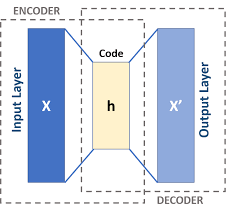
(Quelle:https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png)


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython import display

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape

11490434/11490434 [==============================] - 2s 0us/step


(60000, 28, 28)

In [4]:
# adding a color channel
train_images = train_images[:,:,:,np.newaxis].astype('float32')
# and scale to 0-1
train_images_01 = train_images / 255.

test_images = test_images[:,:,:,np.newaxis]
test_images_01 = test_images / 255.

train_images_01.shape

(60000, 28, 28, 1)

## Encoder

The Encoder is similar to a classification network. Only there is no final classification head at the end.

In [5]:
latent_dim = 8

encoder = tf.keras.Sequential(
    name='encoder',
    layers = [
        layers.InputLayer(input_shape=(28, 28, 1)),
        layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu'),
        layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'),
        layers.Flatten(),
        layers.Dense(latent_dim),
        ]
    )

## Decoder

The Decoder is taking an input and reconstructing an image from this

In [6]:
decoder = tf.keras.Sequential(
    name = 'decoder',
    layers = [
        layers.InputLayer(input_shape=(latent_dim,)),
        layers.Dense(units=7*7*32, activation=tf.nn.relu),
        layers.Reshape(target_shape=(7, 7, 32)),
        layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation='relu'),
        layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation='relu'),
        layers.Conv2DTranspose(filters=1,  kernel_size=3, strides=1, padding="same", activation='sigmoid'),
        ]
    )

## Autoencoder

Combining Encoder-Autoencoder



In [7]:
# Posibility 1
autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

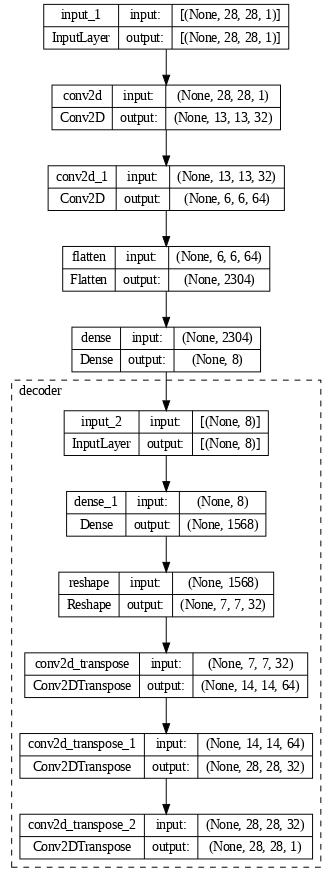

In [8]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, dpi=70, expand_nested=True)

initial model predictions

313/313 [==============================] - 9s 3ms/step


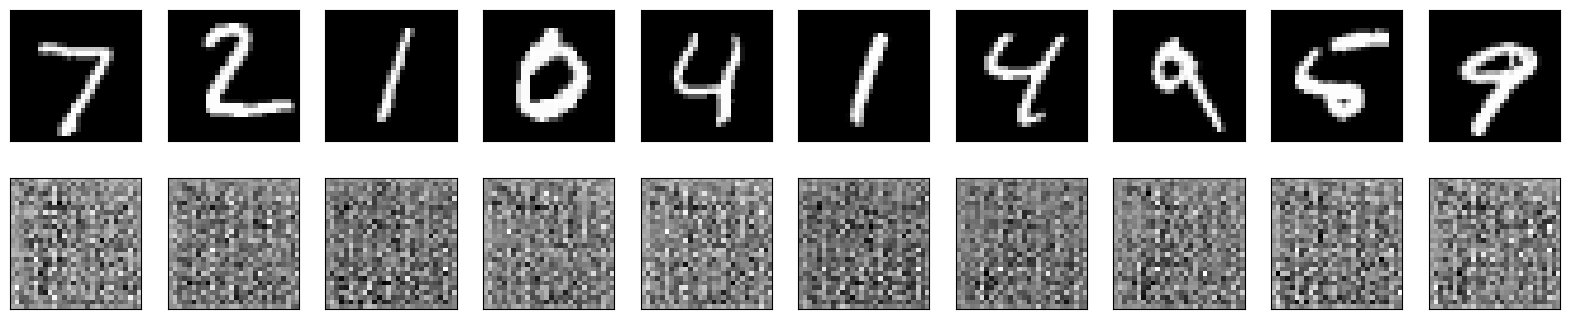

In [9]:
decoded_imgs = autoencoder.predict(test_images_01)

n_plot = 10
plt.figure(figsize=(20, 4))
for i in range(n_plot):
    # display original
    ax = plt.subplot(2, n_plot, i+1)
    plt.imshow(test_images_01[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n_plot, i+n_plot+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Training



In [10]:
autoencoder.fit(
    x = train_images_01,
    y = train_images_01, # input and output are the same (i.e. autoencoder)
    epochs=40,
    batch_size=256,
    shuffle=True,
    validation_data=(test_images_01, test_images_01)
)

Epoch 1/40
235/235 [==============================] - 7s 17ms/step - loss: 0.2711 - val_loss: 0.1675
Epoch 2/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1453 - val_loss: 0.1339
Epoch 3/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1315 - val_loss: 0.1272
Epoch 4/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1266 - val_loss: 0.1239
Epoch 5/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1235 - val_loss: 0.1212
Epoch 6/40
235/235 [==============================] - 4s 16ms/step - loss: 0.1213 - val_loss: 0.1195
Epoch 7/40
235/235 [==============================] - 3s 14ms/step - loss: 0.1198 - val_loss: 0.1185
Epoch 8/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1186 - val_loss: 0.1175
Epoch 9/40
235/235 [==============================] - 3s 12ms/step - loss: 0.1177 - val_loss: 0.1167
Epoch 10/40
235/235 [==============================] - 4s 18ms/step - loss: 0.1169 - val_lo

ouput after the training

313/313 [==============================] - 1s 2ms/step


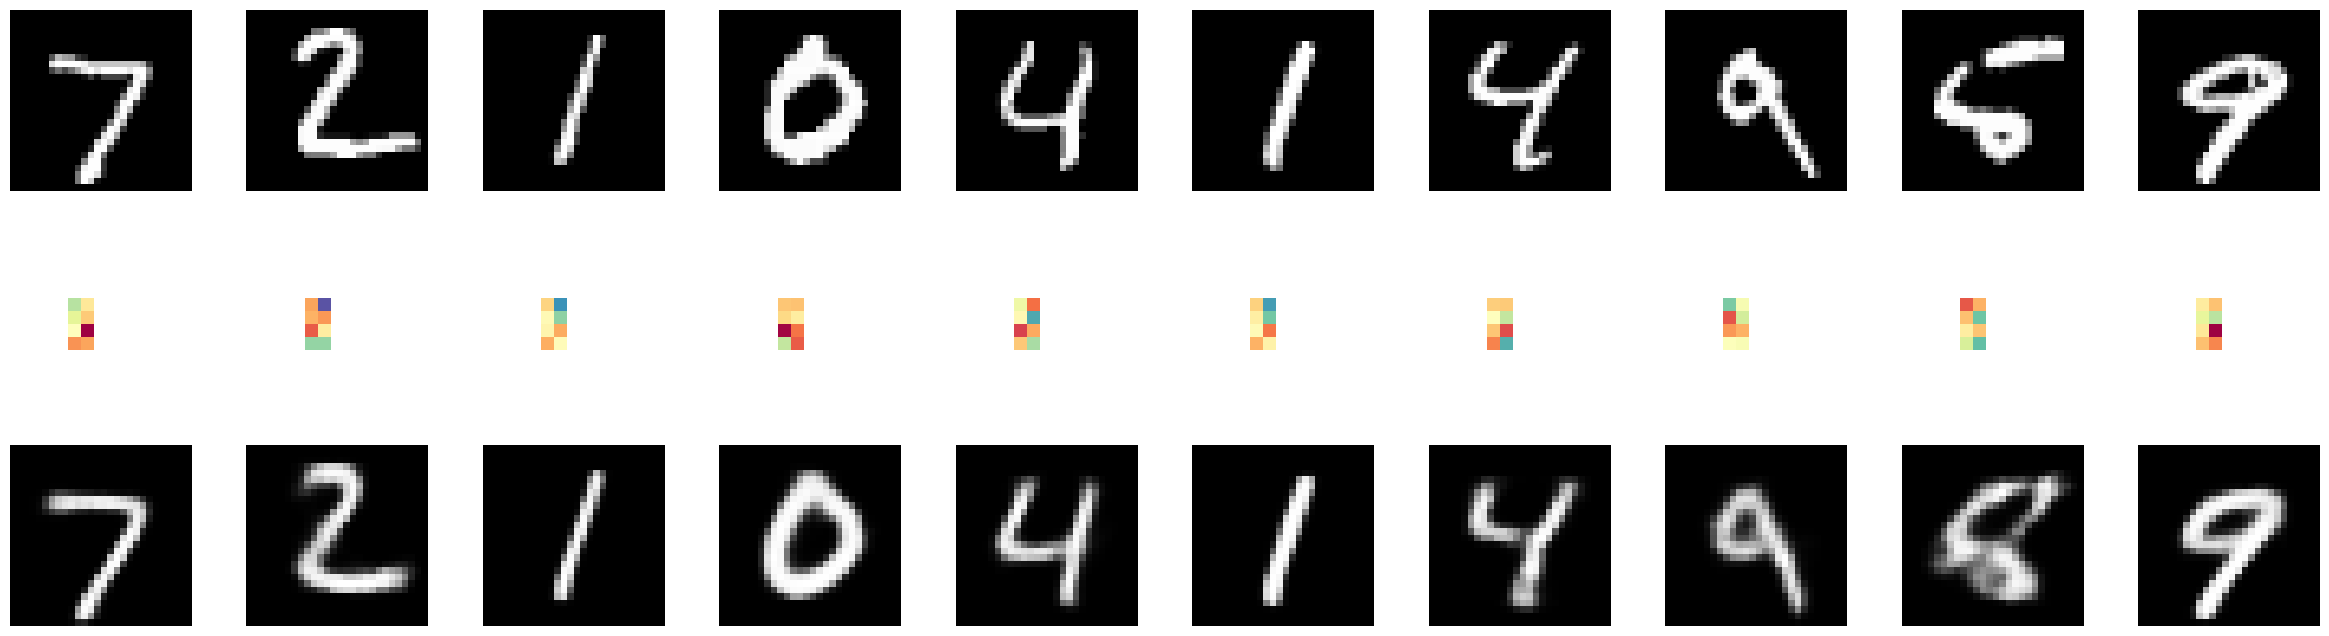

In [11]:
encoded_imgs = encoder.predict(test_images_01)
de_encoded_imgs = decoder.predict(encoded_imgs)

n = 10
plt.figure(figsize=(30, 8))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(test_images_01[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # encodint original
    ax = plt.subplot(3, n, n+i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 2), cmap=plt.cm.Spectral, vmin=-10, vmax=10)
    plt.xlim((-5, 9))
    plt.ylim((-5, 9))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(3, n, 2*n+i+1)
    plt.imshow(de_encoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

# Exploring the latent Space

We can feed the decoder any input

1/1 [==============================] - 0s 17ms/step


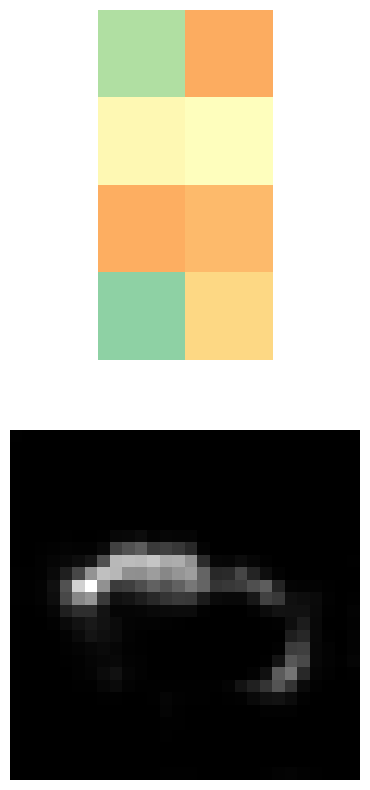

In [20]:
#np.random.seed(44)
random_encoding = (np.random.rand(latent_dim)-0.5)*10

random_img = decoder.predict(random_encoding[np.newaxis]).reshape((28,28))

plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.imshow(random_encoding.reshape((4,2)),  cmap=plt.cm.Spectral, vmin=-10, vmax=10)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(random_img, cmap='gray')
_ = plt.axis('off')

## Shifts in latent space

1/1 [==============================] - 0s 22ms/step


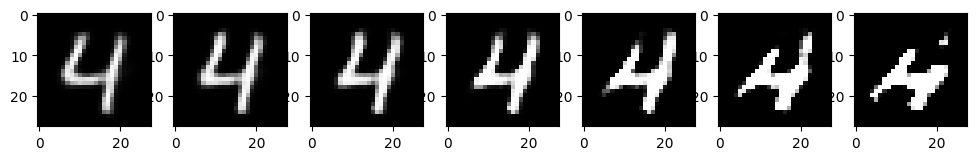

In [25]:
code = encoder.predict(test_images_01[4][None,:,:,:])
direction = np.random.randn(*code.shape)
displacements = [0,1,2,4,8,16, 32]
plt.figure(figsize=(12,10))
for i,d in enumerate(displacements):
    plt.subplot(1,len(displacements),i+1)
    img = decoder.predict(code+direction*d)
    _ = plt.imshow(img.squeeze(), cmap='gray')

### Aufgaben
1. Dimension des latenten Raumes
  - Verlgleichen Sie die Resultate für unterschiedlich große latente Räumen
    - Wieviele Dimensionen muss der latente Raum mindestens haben?

2. Rechnen im latenten Raum
  - Berechnen Sie die latente Darstellung für 2 Testbilder (encoded images)
  -  Erstellen Sie ein gewichtetes Mittel der beiden Embeddings  $\alpha \vec{e_1} + (1-\alpha) \vec{e_2}$ für verschiedene Werte von $\alpha$ zwischen 0 und 1
  - Dekodieren Sie nun wieder den gemittelten Code
  - Bonus: Wie sieht das Ergebniss aus, wenn man dieses gewichtete Mittel direkt im Pixelraum ausführt?